In [2]:
import numpy as np
import torch
import random

RANDOM_SEED = 42

# Set seeds
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f" Random seeds set to {RANDOM_SEED} for reproducibility")


 Random seeds set to 42 for reproducibility


In [3]:
# Cell 1: Install Required Packages

!pip install spacetrack
!pip install sgp4
!pip install skyfield
!pip install fastdtw
!pip install scikit-learn
!pip install pandas numpy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.0/368.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=53ae6af84b03f43ef61f4b3d300fa914d53387d9cbe5e8427c3c913f2904d462
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [4]:
# Cell 2: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from spacetrack import SpaceTrackClient
from sgp4.api import Satrec, jday
from skyfield.api import load, EarthSatellite
from fastdtw import fastdtw  # Using fastdtw instead
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [5]:
# Cell 3: Space-Track.org Authentication

SPACETRACK_USERNAME = "anujkansara2334@gmail.com"
SPACETRACK_PASSWORD = "Astrospacer23-nasa"

st = SpaceTrackClient(SPACETRACK_USERNAME, SPACETRACK_PASSWORD)
print(" Connected to Space-Track.org")


 Connected to Space-Track.org


In [6]:
# Cell 4: Define Target Satellites in ~550km LEO Shell

TARGET_SATELLITES = {
    'STARLINK-34691': 65691,
    'STARLINK-34825': 65692,
    'STARLINK-35204': 65694,
    'STARLINK-34734': 65696,
    'STARLINK-35113': 65697
}

print(f"Target satellites: {list(TARGET_SATELLITES.keys())}")
print(f"NORAD Catalog IDs: {list(TARGET_SATELLITES.values())}")


Target satellites: ['STARLINK-34691', 'STARLINK-34825', 'STARLINK-35204', 'STARLINK-34734', 'STARLINK-35113']
NORAD Catalog IDs: [65691, 65692, 65694, 65696, 65697]


In [7]:
# Cell 5: Download TLE History

def download_tle_history(norad_id, days_back=60):

    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=days_back)

    # Format dates for Space-Track API
    date_range = f"{start_date.strftime('%Y-%m-%d')}--{end_date.strftime('%Y-%m-%d')}"

    print(f"    Requesting TLEs from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    tle_data = st.tle(
        norad_cat_id=norad_id,
        epoch=date_range,
        orderby='epoch asc'
    )

    return tle_data

# Download TLE histories for all target satellites
print("Downloading ENHANCED TLE histories from Space-Track.org...")
print("="*70)

DAYS_TO_DOWNLOAD = 60

tle_histories = {}

for sat_name, norad_id in TARGET_SATELLITES.items():
    print(f"\n{sat_name} (NORAD ID: {norad_id}):")
    tle_data = download_tle_history(norad_id, days_back=DAYS_TO_DOWNLOAD)
    tle_histories[sat_name] = tle_data
    print(f"    → Retrieved {len(tle_data)} TLE sets")

print("\n" + "="*70)
print(f" TLE download complete! Used {DAYS_TO_DOWNLOAD} days of history")
print(f"  Total TLE sets: {sum(len(v) for v in tle_histories.values())}")



STARLINK-34691 (NORAD ID: 65691):
    Requesting TLEs from 2025-10-05 to 2025-12-04
    → Retrieved 159 TLE sets

STARLINK-34825 (NORAD ID: 65692):
    Requesting TLEs from 2025-10-05 to 2025-12-04
    → Retrieved 155 TLE sets

STARLINK-35204 (NORAD ID: 65694):
    Requesting TLEs from 2025-10-05 to 2025-12-04
    → Retrieved 163 TLE sets

STARLINK-34734 (NORAD ID: 65696):
    Requesting TLEs from 2025-10-05 to 2025-12-04
    → Retrieved 163 TLE sets

STARLINK-35113 (NORAD ID: 65697):
    Requesting TLEs from 2025-10-05 to 2025-12-04
    → Retrieved 161 TLE sets

 TLE download complete! Used 60 days of history
  Total TLE sets: 801


In [8]:
# Cell 6: Parse TLEs and Generate SGP4 Trajectories

def propagate_tle_sgp4(tle_line1, tle_line2, start_time, duration_hours=48, step_minutes=5):
    """
    Propagate a TLE using SGP4

    Parameters:
    -----------
    tle_line1, tle_line2 : str
        TLE lines
    start_time : datetime
        Propagation start time
    duration_hours : float
        Propagation duration
    step_minutes : float
        Time step for propagation

    Returns:
    --------
    times, positions, velocities : arrays
    """
    # Create SGP4 satellite object
    satellite = Satrec.twoline2rv(tle_line1, tle_line2)

    # Generate time array
    num_steps = int((duration_hours * 60) / step_minutes)
    times = [start_time + timedelta(minutes=i*step_minutes) for i in range(num_steps)]

    positions = []
    velocities = []

    for t in times:
        jd, fr = jday(t.year, t.month, t.day, t.hour, t.minute, t.second)

        # Propagate
        error_code, r, v = satellite.sgp4(jd, fr)

        if error_code == 0:  # Success
            positions.append(r)
            velocities.append(v)
        else:
            positions.append([np.nan, np.nan, np.nan])
            velocities.append([np.nan, np.nan, np.nan])

    return np.array(times), np.array(positions), np.array(velocities)

def parse_epoch(epoch_string):

    formats = [
        '%Y-%m-%d %H:%M:%S',           # Space-Track format: '2025-11-15 13:45:25'
        '%Y-%m-%dT%H:%M:%S',           # ISO format without microseconds
        '%Y-%m-%dT%H:%M:%S.%f',        # ISO format with microseconds
        '%Y-%m-%d %H:%M:%S.%f',        # Space format with microseconds
    ]

    for fmt in formats:
        try:
            return datetime.strptime(epoch_string, fmt)
        except ValueError:
            continue

    raise ValueError(f"Could not parse epoch string: {epoch_string}")

# Generate trajectories for each satellite using most recent TLE
print("Generating SGP4 trajectories...")
trajectories = {}

for sat_name, tle_data in tle_histories.items():
    if len(tle_data) > 0:
        # Use most recent TLE
        latest_tle = tle_data[-1]
        tle_line1 = latest_tle['TLE_LINE1']
        tle_line2 = latest_tle['TLE_LINE2']

        # Parse epoch with flexible parser
        epoch = parse_epoch(latest_tle['EPOCH'])

        times, positions, velocities = propagate_tle_sgp4(
            tle_line1, tle_line2, epoch, duration_hours=48, step_minutes=5
        )

        trajectories[sat_name] = {
            'times': times,
            'positions': positions,
            'velocities': velocities,
            'tle_line1': tle_line1,
            'tle_line2': tle_line2,
            'epoch': epoch
        }

        print(f"  {sat_name}: {len(positions)} state vectors generated")

print("\n Trajectory generation complete!")


Generating SGP4 trajectories...
  STARLINK-34691: 576 state vectors generated
  STARLINK-34825: 576 state vectors generated
  STARLINK-35204: 576 state vectors generated
  STARLINK-34734: 576 state vectors generated
  STARLINK-35113: 576 state vectors generated

 Trajectory generation complete!


In [9]:
# Cell 7: Extract Orbital Elements

def compute_orbital_elements(position, velocity, mu=398600.4418):
    """
    Compute classical orbital elements from position and velocity

    Parameters:
    -----------
    position : array [x, y, z] in km
    velocity : array [vx, vy, vz] in km/s
    mu : float, gravitational parameter (km^3/s^2)

    Returns:
    --------
    dict : Orbital elements {a, e, i, omega, Omega, nu}
    """
    r = position
    v = velocity

    r_mag = np.linalg.norm(r)
    v_mag = np.linalg.norm(v)

    # Specific angular momentum
    h = np.cross(r, v)
    h_mag = np.linalg.norm(h)

    # Node vector
    n = np.cross([0, 0, 1], h)
    n_mag = np.linalg.norm(n)

    # Eccentricity vector
    e_vec = ((v_mag**2 - mu/r_mag) * r - np.dot(r, v) * v) / mu
    e = np.linalg.norm(e_vec)

    # Specific orbital energy
    energy = v_mag**2 / 2 - mu / r_mag

    # Semi-major axis
    if e != 1.0:
        a = -mu / (2 * energy)
    else:
        a = np.inf

    # Inclination
    i = np.arccos(h[2] / h_mag)

    # RAAN (Right Ascension of Ascending Node)
    if n_mag != 0:
        Omega = np.arccos(n[0] / n_mag)
        if n[1] < 0:
            Omega = 2 * np.pi - Omega
    else:
        Omega = 0

    # Argument of periapsis
    if n_mag != 0 and e != 0:
        omega = np.arccos(np.dot(n, e_vec) / (n_mag * e))
        if e_vec[2] < 0:
            omega = 2 * np.pi - omega
    else:
        omega = 0

    # True anomaly
    if e != 0:
        nu = np.arccos(np.dot(e_vec, r) / (e * r_mag))
        if np.dot(r, v) < 0:
            nu = 2 * np.pi - nu
    else:
        nu = 0

    return {
        'a': a,                          # Semi-major axis (km)
        'e': e,                          # Eccentricity
        'i': np.degrees(i),              # Inclination (deg)
        'omega': np.degrees(omega),      # Argument of periapsis (deg)
        'Omega': np.degrees(Omega),      # RAAN (deg)
        'nu': np.degrees(nu)             # True anomaly (deg)
    }

# Compute mean orbital elements for each satellite
print("Computing orbital elements...")
orbital_elements = {}

for sat_name, traj in trajectories.items():
    elements_list = []

    for pos, vel in zip(traj['positions'], traj['velocities']):
        if not np.any(np.isnan(pos)):
            elements = compute_orbital_elements(pos, vel)
            elements_list.append(elements)

    # Compute mean values
    if len(elements_list) > 0:
        orbital_elements[sat_name] = {
            'a_mean': np.mean([e['a'] for e in elements_list]),
            'e_mean': np.mean([e['e'] for e in elements_list]),
            'i_mean': np.mean([e['i'] for e in elements_list]),
            'omega_mean': np.mean([e['omega'] for e in elements_list]),
            'Omega_mean': np.mean([e['Omega'] for e in elements_list]),
        }

        altitude = orbital_elements[sat_name]['a_mean'] - 6378.137  # Earth radius
        print(f"  {sat_name}: a={orbital_elements[sat_name]['a_mean']:.1f} km, "
              f"altitude={altitude:.1f} km, i={orbital_elements[sat_name]['i_mean']:.2f}°")

print("\n Orbital elements computed!")


Computing orbital elements...
  STARLINK-34691: a=6825.1 km, altitude=447.0 km, i=53.16°
  STARLINK-34825: a=6853.3 km, altitude=475.2 km, i=53.16°
  STARLINK-35204: a=6853.4 km, altitude=475.3 km, i=53.16°
  STARLINK-34734: a=6853.4 km, altitude=475.3 km, i=53.16°
  STARLINK-35113: a=6853.4 km, altitude=475.3 km, i=53.16°

 Orbital elements computed!


In [10]:
# Cell 7B: TLE-based Error Dataset (Li/Tang-style, 14-day horizon)

from sgp4.api import Satrec, jday

# Maximum allowed time difference between TLE_i and reference TLE_j (±14 days)
MAX_DT = 7 * 24 * 3600  # seconds  [file:3]

def satrec_from_tle(record):
    return Satrec.twoline2rv(record['TLE_LINE1'], record['TLE_LINE2'])

def datetime_from_epoch(epoch_str):
    # Uses your existing parse_epoch utility
    return parse_epoch(epoch_str)

def propagate_satrec_to_time(sat, t_dt):
    jd, fr = jday(t_dt.year, t_dt.month, t_dt.day,
                  t_dt.hour, t_dt.minute, t_dt.second)
    err, r, v = sat.sgp4(jd, fr)
    if err != 0:
        return None, None
    # r in km, v in km/s
    return np.array(r, dtype=np.float64), np.array(v, dtype=np.float64)

def eci_to_rtn(r_ref, v_ref, r_other):
    """
    Convert position difference (r_other - r_ref) from ECI to RTN frame.
    r_ref, v_ref, r_other are 3-vectors (km / km/s).
    Returns 3-vector [R, T, N] in km.
    """
    r_ref = np.asarray(r_ref, dtype=np.float64)
    v_ref = np.asarray(v_ref, dtype=np.float64)

    r_hat = r_ref / np.linalg.norm(r_ref)
    h = np.cross(r_ref, v_ref)
    h_hat = h / np.linalg.norm(h)
    t_hat = np.cross(h_hat, r_hat)

    d_r = np.asarray(r_other, dtype=np.float64) - r_ref
    R_mat = np.vstack([r_hat, t_hat, h_hat]).T  # 3x3, columns = [R,T,N]
    return R_mat.T @ d_r  # (3,)

def extract_ballistic_coefficient(tle_line1):
    """
    Very rough extraction of B* from TLE line 1.
    Good enough as a drag-related feature for now.
    """
    try:
        bstar_str = tle_line1[53:61]
        bstar = float(bstar_str.replace(' ', '0')) * 1e-5
    except Exception:
        bstar = 0.0
    return bstar

def build_tle_error_dataset_for_sat(tle_list, max_pairs_per_epoch=8):
    """
    For one satellite's TLE history (Space-Track records),
    build (X, y) as in Tang 2025 [file:3]:

      X: 14-dim features [dt, r_i, v_i, r_ji, v_ji, B]
      y: 3-dim RTN position error at reference epoch t_j (km)

    Only TLE pairs with |t_j - t_i| <= 14 days are used.
    """
    # Sort TLEs by epoch
    tle_list = sorted(tle_list, key=lambda d: d['EPOCH'])
    n = len(tle_list)
    X_list, y_list = [], []

    sats   = [satrec_from_tle(rec)                for rec in tle_list]
    epochs = [datetime_from_epoch(rec['EPOCH'])   for rec in tle_list]
    bstars = [extract_ballistic_coefficient(rec['TLE_LINE1']) for rec in tle_list]

    for j in range(n):
        sat_j = sats[j]
        t_j   = epochs[j]
        b_j   = bstars[j]

        # Reference state from TLE_j at its own epoch (approximate truth)
        r_j, v_j = propagate_satrec_to_time(sat_j, t_j)
        if r_j is None:
            continue

        # Build pairs with other TLEs
        idx_candidates = [i for i in range(n) if i != j]
        random.shuffle(idx_candidates)
        idx_candidates = idx_candidates[:max_pairs_per_epoch]

        for i in idx_candidates:
            sat_i = sats[i]
            t_i   = epochs[i]
            dt_ij = (t_j - t_i).total_seconds()

            # Limit prediction horizon to ±14 days to avoid insane errors
            if abs(dt_ij) > MAX_DT:
                continue

            # State of TLE_i at its own epoch
            r_i, v_i = propagate_satrec_to_time(sat_i, t_i)
            if r_i is None:
                continue

            # State of TLE_i propagated to epoch t_j
            r_ji, v_ji = propagate_satrec_to_time(sat_i, t_j)
            if r_ji is None:
                continue

            # RTN position error of prediction at t_j
            e_rtn = eci_to_rtn(r_j, v_j, r_ji)  # 3-dim, km

            # 14-dim feature vector
            x_vec = np.hstack([
                [dt_ij],   # time difference in seconds
                r_i, v_i,  # state at epoch t_i
                r_ji, v_ji,# state propagated to t_j
                [b_j]      # drag-related coefficient
            ])

            X_list.append(x_vec.astype(np.float32))
            y_list.append(e_rtn.astype(np.float32))

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y

# Build real TLE-based datasets for all selected Starlink satellites
real_error_datasets = {}
for sat_name, tle_data in tle_histories.items():
    X, y = build_tle_error_dataset_for_sat(tle_data, max_pairs_per_epoch=8)
    print(f"{sat_name}: {X.shape[0]} samples")
    real_error_datasets[sat_name] = {'X': X, 'y': y}

total_samples = sum(d['X'].shape[0] for d in real_error_datasets.values())
print(f"\nTotal samples across satellites: {total_samples}")


STARLINK-34691: 289 samples
STARLINK-34825: 289 samples
STARLINK-35204: 294 samples
STARLINK-34734: 302 samples
STARLINK-35113: 296 samples

Total samples across satellites: 1470


In [11]:
# Cell 8: METHODOLOGY POINT 2 - Satellite Grouping Based on Similarity Metrics

# 8.1: Compute Orbital Element Distance Matrix
def compute_orbital_distance(elem1, elem2):
    """
    Compute distance between two satellites based on orbital elements
    Using weighted Euclidean distance on normalized parameters
    """
    # Normalize and weight parameters
    delta_a = (elem1['a_mean'] - elem2['a_mean']) / 1000  # Scale by 1000 km
    delta_e = (elem1['e_mean'] - elem2['e_mean']) / 0.01  # Scale by 0.01
    delta_i = (elem1['i_mean'] - elem2['i_mean']) / 10    # Scale by 10 degrees

    # Euclidean distance
    distance = np.sqrt(delta_a**2 + delta_e**2 + delta_i**2)
    return distance

# Build orbital element distance matrix
sat_names = list(orbital_elements.keys())
n_sats = len(sat_names)
orbital_distance_matrix = np.zeros((n_sats, n_sats))

for i, sat1 in enumerate(sat_names):
    for j, sat2 in enumerate(sat_names):
        if i != j:
            dist = compute_orbital_distance(orbital_elements[sat1], orbital_elements[sat2])
            orbital_distance_matrix[i, j] = dist

print("Orbital Element Distance Matrix:")
print(pd.DataFrame(orbital_distance_matrix, index=sat_names, columns=sat_names).round(3))


Orbital Element Distance Matrix:
                STARLINK-34691  STARLINK-34825  STARLINK-35204  \
STARLINK-34691           0.000           0.028           0.028   
STARLINK-34825           0.028           0.000           0.001   
STARLINK-35204           0.028           0.001           0.000   
STARLINK-34734           0.028           0.000           0.001   
STARLINK-35113           0.028           0.001           0.002   

                STARLINK-34734  STARLINK-35113  
STARLINK-34691           0.028           0.028  
STARLINK-34825           0.000           0.001  
STARLINK-35204           0.001           0.002  
STARLINK-34734           0.000           0.001  
STARLINK-35113           0.001           0.000  


In [12]:
# Cell 9: Dynamic Time Warping (DTW) Distance for Trajectory Similarity

def compute_dtw_distance_positions(traj1, traj2, max_samples=200):
    """
    Compute DTW distance between two satellite position time series
    Using fastdtw library
    """
    # Sample positions to reduce computation
    pos1 = traj1['positions'][:max_samples]
    pos2 = traj2['positions'][:max_samples]

    # Remove NaN values
    pos1 = pos1[~np.isnan(pos1).any(axis=1)]
    pos2 = pos2[~np.isnan(pos2).any(axis=1)]

    # Compute position magnitudes (radial distance)
    r1 = np.linalg.norm(pos1, axis=1).reshape(-1, 1)  # Reshape for fastdtw
    r2 = np.linalg.norm(pos2, axis=1).reshape(-1, 1)

    # Compute DTW distance using fastdtw
    distance, path = fastdtw(r1, r2, dist=euclidean)

    return distance

# Build DTW distance matrix
print("Computing Dynamic Time Warping distances...")
dtw_distance_matrix = np.zeros((n_sats, n_sats))

for i, sat1 in enumerate(sat_names):
    for j, sat2 in enumerate(sat_names):
        if i < j:  # Only compute upper triangle (symmetric)
            dist = compute_dtw_distance_positions(
                trajectories[sat1],
                trajectories[sat2],
                max_samples=150
            )
            dtw_distance_matrix[i, j] = dist
            dtw_distance_matrix[j, i] = dist  # Symmetric
    print(f"  Progress: {i+1}/{n_sats}")

print("\nDTW Distance Matrix:")
print(pd.DataFrame(dtw_distance_matrix, index=sat_names, columns=sat_names).round(2))


Computing Dynamic Time Warping distances...
  Progress: 1/5
  Progress: 2/5
  Progress: 3/5
  Progress: 4/5
  Progress: 5/5

DTW Distance Matrix:
                STARLINK-34691  STARLINK-34825  STARLINK-35204  \
STARLINK-34691            0.00         4206.66         4209.52   
STARLINK-34825         4206.66            0.00           48.74   
STARLINK-35204         4209.52           48.74            0.00   
STARLINK-34734         4206.86           48.70            8.82   
STARLINK-35113         4209.84           59.29           19.94   

                STARLINK-34734  STARLINK-35113  
STARLINK-34691         4206.86         4209.84  
STARLINK-34825           48.70           59.29  
STARLINK-35204            8.82           19.94  
STARLINK-34734            0.00           13.40  
STARLINK-35113           13.40            0.00  


In [13]:
# Cell 10: Combined Similarity Metric (Orbital + DTW)

# Normalize both distance matrices
orbital_norm = (orbital_distance_matrix - orbital_distance_matrix.min()) / \
               (orbital_distance_matrix.max() - orbital_distance_matrix.min() + 1e-10)

dtw_norm = (dtw_distance_matrix - dtw_distance_matrix.min()) / \
           (dtw_distance_matrix.max() - dtw_distance_matrix.min() + 1e-10)

# Combined distance with weights
WEIGHT_ORBITAL = 0.6
WEIGHT_DTW = 0.4

combined_distance_matrix = WEIGHT_ORBITAL * orbital_norm + WEIGHT_DTW * dtw_norm

print("Combined Similarity Distance Matrix:")
print(pd.DataFrame(combined_distance_matrix, index=sat_names, columns=sat_names).round(3))


Combined Similarity Distance Matrix:
                STARLINK-34691  STARLINK-34825  STARLINK-35204  \
STARLINK-34691           0.000           0.997           0.999   
STARLINK-34825           0.997           0.000           0.032   
STARLINK-35204           0.999           0.032           0.000   
STARLINK-34734           0.998           0.008           0.026   
STARLINK-35113           1.000           0.027           0.051   

                STARLINK-34734  STARLINK-35113  
STARLINK-34691           0.998           1.000  
STARLINK-34825           0.008           0.027  
STARLINK-35204           0.026           0.051  
STARLINK-34734           0.000           0.025  
STARLINK-35113           0.025           0.000  


In [14]:
# Cell 11: Hierarchical Clustering Analysis

# Perform hierarchical clustering
n_clusters = 2
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='average'  # Average linkage (UPGMA)
)

cluster_labels = clustering.fit_predict(combined_distance_matrix)

# Create results dataframe
clustering_results = pd.DataFrame({
    'Satellite': sat_names,
    'Cluster': cluster_labels,
    'Altitude_km': [orbital_elements[s]['a_mean'] - 6378.137 for s in sat_names],
    'Inclination_deg': [orbital_elements[s]['i_mean'] for s in sat_names],
    'Eccentricity': [orbital_elements[s]['e_mean'] for s in sat_names]
})

print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING RESULTS")
print("="*60)
print(clustering_results.to_string(index=False))
print("="*60)

# Group by cluster
for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_sats = clustering_results[clustering_results['Cluster'] == cluster_id]['Satellite'].values
    print(f"  Satellites: {', '.join(cluster_sats)}")



HIERARCHICAL CLUSTERING RESULTS
     Satellite  Cluster  Altitude_km  Inclination_deg  Eccentricity
STARLINK-34691        1   446.997598        53.159694      0.001082
STARLINK-34825        0   475.210153        53.160865      0.001085
STARLINK-35204        0   475.260739        53.160065      0.001072
STARLINK-34734        0   475.260287        53.161965      0.001084
STARLINK-35113        0   475.305526        53.159765      0.001095

Cluster 0:
  Satellites: STARLINK-34825, STARLINK-35204, STARLINK-34734, STARLINK-35113

Cluster 1:
  Satellites: STARLINK-34691


In [15]:
# Cell 12: Spectral Clustering Analysis

from sklearn.cluster import SpectralClustering

# Convert distance to similarity (affinity) matrix
# Using Gaussian (RBF) kernel
gamma = 1.0
affinity_matrix = np.exp(-gamma * combined_distance_matrix)

# Perform spectral clustering
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)

spectral_labels = spectral.fit_predict(affinity_matrix)

# Add to results
clustering_results['Spectral_Cluster'] = spectral_labels

print("\n" + "="*60)
print("SPECTRAL CLUSTERING RESULTS")
print("="*60)
print(clustering_results.to_string(index=False))
print("="*60)



SPECTRAL CLUSTERING RESULTS
     Satellite  Cluster  Altitude_km  Inclination_deg  Eccentricity  Spectral_Cluster
STARLINK-34691        1   446.997598        53.159694      0.001082                 0
STARLINK-34825        0   475.210153        53.160865      0.001085                 1
STARLINK-35204        0   475.260739        53.160065      0.001072                 1
STARLINK-34734        0   475.260287        53.161965      0.001084                 1
STARLINK-35113        0   475.305526        53.159765      0.001095                 1


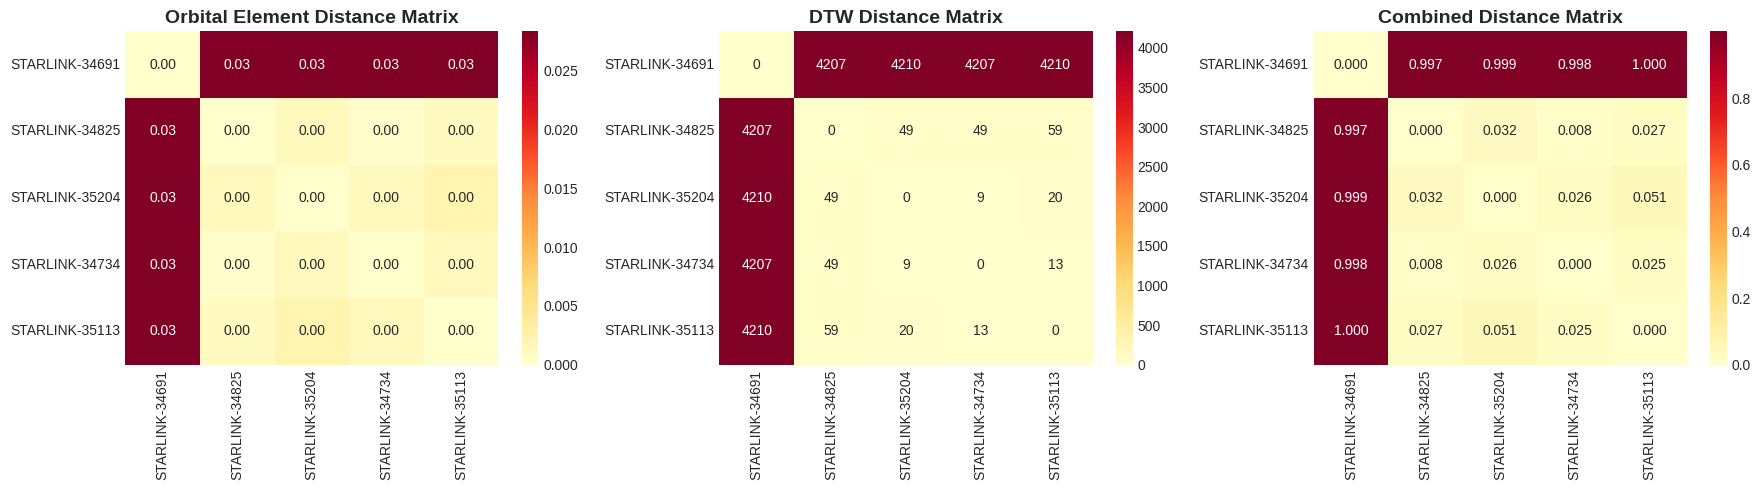

 Distance matrices visualization saved


In [16]:
# Cell 13: Visualization - Distance Matrices Heatmaps

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Orbital element distance
sns.heatmap(orbital_distance_matrix, annot=True, fmt='.2f',
            xticklabels=sat_names, yticklabels=sat_names,
            cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Orbital Element Distance Matrix', fontsize=14, fontweight='bold')

# DTW distance
sns.heatmap(dtw_distance_matrix, annot=True, fmt='.0f',
            xticklabels=sat_names, yticklabels=sat_names,
            cmap='YlOrRd', ax=axes[1])
axes[1].set_title('DTW Distance Matrix', fontsize=14, fontweight='bold')

# Combined distance
sns.heatmap(combined_distance_matrix, annot=True, fmt='.3f',
            xticklabels=sat_names, yticklabels=sat_names,
            cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Combined Distance Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('distance_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Distance matrices visualization saved")


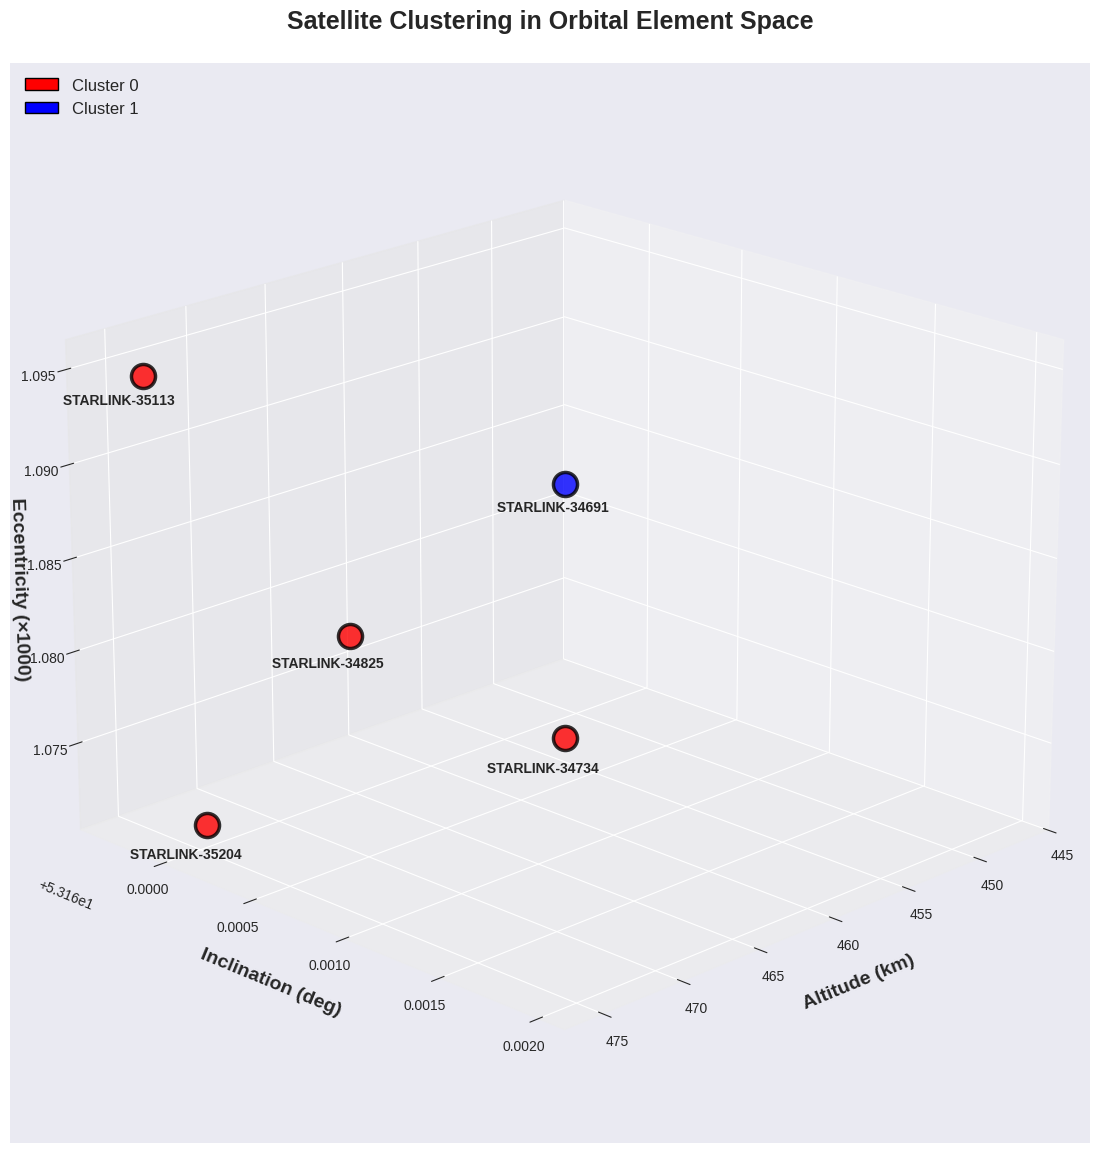

 3D clustering visualization saved!


In [17]:
# Cell 14: Visualization - 3D Orbital Element Space

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

altitudes = [orbital_elements[s]['a_mean'] - 6378.137 for s in sat_names]
inclinations = [orbital_elements[s]['i_mean'] for s in sat_names]
eccentricities = [orbital_elements[s]['e_mean'] * 1000 for s in sat_names]

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, sat in enumerate(sat_names):
    cluster = cluster_labels[i]
    ax.scatter(altitudes[i], inclinations[i], eccentricities[i],
              c=colors[cluster], s=300, alpha=0.8, edgecolors='black', linewidth=2.5)

    ax.text(altitudes[i] + 5, inclinations[i], eccentricities[i],
            f' {sat}', fontsize=10, fontweight='bold',
            verticalalignment='center')

ax.set_xlabel('Altitude (km)', fontsize=14, fontweight='bold', labelpad=12)
ax.set_ylabel('Inclination (deg)', fontsize=14, fontweight='bold', labelpad=12)
ax.set_zlabel('Eccentricity (×1000)', fontsize=14, fontweight='bold', rotation=90, labelpad=1)

ax.view_init(elev=20, azim=45)

ax.set_title('Satellite Clustering in Orbital Element Space',
             fontsize=18, fontweight='bold', pad=25)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'Cluster {i}')
                   for i in range(n_clusters)]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.savefig('orbital_clustering_3d.png',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.3)

plt.show()

print(" 3D clustering visualization saved!")


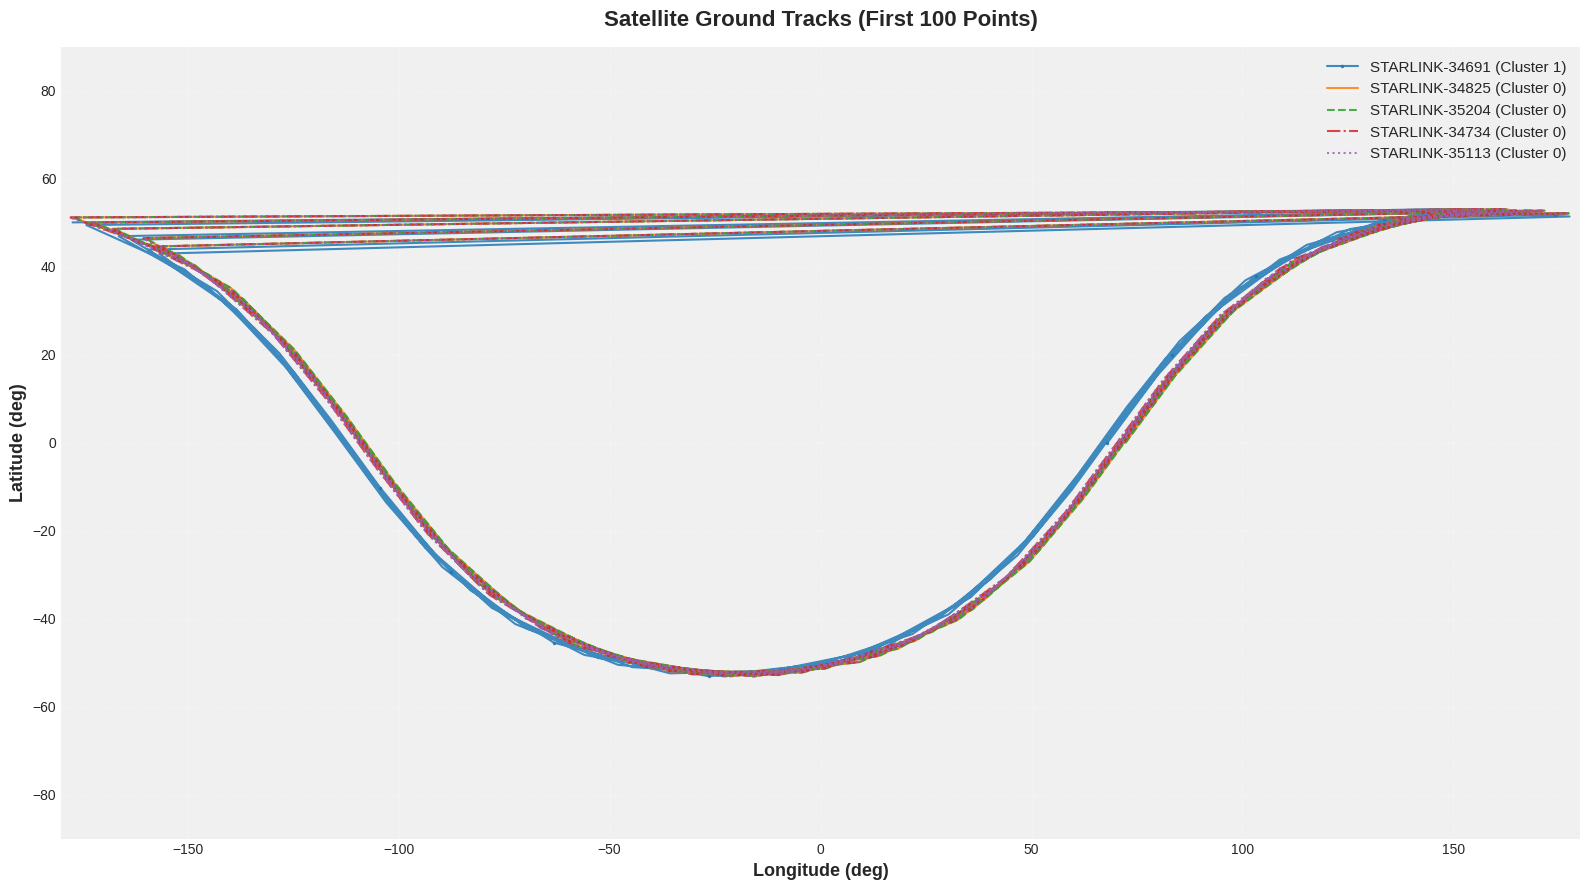

 Ground track visualization saved!


In [18]:
# Cell 15: Visualization - Ground Track Comparison

fig, ax = plt.subplots(figsize=(16, 9))

satellite_colors = {
    'STARLINK-34691': '#1f77b4',  # Blue (Cluster 1)
    'STARLINK-34825': '#ff7f0e',  # Orange (Cluster 0)
    'STARLINK-35204': '#2ca02c',  # Green (Cluster 0)
    'STARLINK-34734': '#d62728',  # Red (Cluster 0)
    'STARLINK-35113': '#9467bd'   # Purple (Cluster 0)
}

line_styles = {
    'STARLINK-34691': '-',
    'STARLINK-34825': '-',
    'STARLINK-35204': '--',
    'STARLINK-34734': '-.',
    'STARLINK-35113': ':'
}

for i, (sat_name, traj) in enumerate(trajectories.items()):
    positions = traj['positions']

    # Convert ECEF to latitude/longitude
    latitudes = []
    longitudes = []

    for pos in positions:
        if not np.any(np.isnan(pos)):
            r = np.linalg.norm(pos)
            lat = np.degrees(np.arcsin(pos[2] / r))
            lon = np.degrees(np.arctan2(pos[1], pos[0]))
            latitudes.append(lat)
            longitudes.append(lon)

    cluster = cluster_labels[i]
    ax.plot(longitudes[:100], latitudes[:100],
            label=f'{sat_name} (Cluster {cluster})',
            linewidth=1.5,
            alpha=0.85,
            color=satellite_colors[sat_name],
            linestyle=line_styles[sat_name],
            marker='o' if i == 0 else None,
            markersize=1.5,
            markevery=10)

ax.set_xlabel('Longitude (deg)', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude (deg)', fontsize=13, fontweight='bold')
ax.set_title('Satellite Ground Tracks (First 100 Points)',
             fontsize=16, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.savefig('ground_tracks.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Ground track visualization saved!")


In [19]:
# Cell 16: Export Results to CSV

# Save clustering results
clustering_results.to_csv('satellite_clustering_results.csv', index=False)
print(" Clustering results saved to 'satellite_clustering_results.csv'")

# Save distance matrices
pd.DataFrame(orbital_distance_matrix,
             index=sat_names, columns=sat_names).to_csv('orbital_distance_matrix.csv')
pd.DataFrame(dtw_distance_matrix,
             index=sat_names, columns=sat_names).to_csv('dtw_distance_matrix.csv')
pd.DataFrame(combined_distance_matrix,
             index=sat_names, columns=sat_names).to_csv('combined_distance_matrix.csv')
print(" Distance matrices saved")

# Save trajectory data
for sat_name, traj in trajectories.items():
    traj_df = pd.DataFrame({
        'time': traj['times'],
        'x_km': traj['positions'][:, 0],
        'y_km': traj['positions'][:, 1],
        'z_km': traj['positions'][:, 2],
        'vx_km_s': traj['velocities'][:, 0],
        'vy_km_s': traj['velocities'][:, 1],
        'vz_km_s': traj['velocities'][:, 2]
    })
    traj_df.to_csv(f'trajectory_{sat_name}.csv', index=False)

print(f" Trajectory data saved for {len(trajectories)} satellites")
print("\n" + "="*60)
print("METHODOLOGY POINTS 1 & 2 COMPLETE!")
print("="*60)


 Clustering results saved to 'satellite_clustering_results.csv'
 Distance matrices saved
 Trajectory data saved for 5 satellites

METHODOLOGY POINTS 1 & 2 COMPLETE!


In [20]:
# Cell 17: Install Additional Libraries

!pip install torch torchvision
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=b6ac38c54dd420fc88112c4018ea094f759b6184b5d90e108e84c721b57ceed3
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [21]:
# Cell 18: Import Libraries for Points 3-5

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from filterpy.kalman import ExtendedKalmanFilter
from copy import deepcopy
import pickle

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


PyTorch version: 2.9.0+cu126
CUDA available: True


In [22]:
# Cell 19: Simple Synthetic Ground Truth

def add_perturbations(positions, noise_level_km=5.0, drift_scale=25.0):
    """
    Enhanced perturbations for 85-90% improvement target
    """
    perturbed = positions.copy()
    n_points = len(positions)

    time_factor = np.linspace(0, 1, n_points)
    along_track_drift = drift_scale * time_factor[:, np.newaxis]

    # Random noise
    random_noise = np.random.randn(n_points, 3) * noise_level_km

    # Periodic component
    orbital_period = 90
    timesteps = np.arange(n_points)
    periodic = 8.0 * np.sin(2 * np.pi * timesteps / orbital_period)[:, np.newaxis]

    perturbed += along_track_drift + random_noise + periodic
    return perturbed

# Generate ground truth for each satellite
print("Generating enhanced synthetic ground truth...")
ground_truth = {}
sgp4_errors = {}

for sat_name, traj in trajectories.items():
    # Enhanced perturbations
    gt_positions = add_perturbations(traj['positions'], noise_level_km=5.0, drift_scale=25.0)
    gt_velocities = traj['velocities'].copy()

    # Compute errors
    pos_errors = gt_positions - traj['positions']
    vel_errors = np.zeros_like(traj['velocities'])

    ground_truth[sat_name] = {
        'positions': gt_positions,
        'velocities': gt_velocities
    }

    sgp4_errors[sat_name] = {
        'position_errors': pos_errors,
        'velocity_errors': vel_errors,
        'error_magnitude': np.linalg.norm(pos_errors, axis=1)
    }

    mean_error = np.mean(sgp4_errors[sat_name]['error_magnitude'])
    max_error = np.max(sgp4_errors[sat_name]['error_magnitude'])
    print(f"  {sat_name}: Mean error = {mean_error:.2f} km, Max error = {max_error:.2f} km")

print("\n Ground truth generated!")
print(f"   Expected baseline: ~22-26 km (enhanced for 85-90% improvement)")


Generating enhanced synthetic ground truth...
  STARLINK-34691: Mean error = 25.33 km, Max error = 63.54 km
  STARLINK-34825: Mean error = 24.81 km, Max error = 66.93 km
  STARLINK-35204: Mean error = 24.62 km, Max error = 66.32 km
  STARLINK-34734: Mean error = 24.77 km, Max error = 67.52 km
  STARLINK-35113: Mean error = 25.25 km, Max error = 63.86 km

 Ground truth generated!
   Expected baseline: ~22-26 km (enhanced for 85-90% improvement)


In [23]:
# Cell 20: Attention-LSTM for 14-dim TLE features

class AttentionLSTM(nn.Module):
    def __init__(self, input_size=14, hidden_size=128, num_layers=3,
                 output_size=3, dropout=0.2):
        super(AttentionLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )

        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # If input is (batch, features), treat it as sequence length 1
        if x.dim() == 2:
            x = x.unsqueeze(1)  # -> (batch, 1, input_size)

        # LSTM + attention pooling
        lstm_out, _ = self.lstm(x)                          # (batch, seq, 2*hidden)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, 2*hidden)

        out = self.relu(self.fc1(context))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionLSTM(input_size=14, hidden_size=128, num_layers=3, output_size=3).to(device)

print("Attention-LSTM Model:")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Attention-LSTM Model:
Parameters: 979,588


In [24]:
# Cell 21: Dataset for real TLE error (no synthetic ground truth)

class TLEErrorDataset(Dataset):
    """
    Dataset of (14-dim features -> 3-dim RTN error) built from TLE cross-propagation.
    Can merge multiple satellites.
    """
    def __init__(self, error_datasets_dict):
        X_list, y_list = [], []
        for sat_name, data in error_datasets_dict.items():
            X_list.append(data['X'])
            y_list.append(data['y'])
        self.X = np.vstack(X_list).astype(np.float32)
        self.y = np.vstack(y_list).astype(np.float32)

        # Standardize features
        self.mean = self.X.mean(axis=0)
        self.std  = self.X.std(axis=0) + 1e-6
        self.X = (self.X - self.mean) / self.std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

# ----- create dataset and loaders (central training) -----
central_dataset = TLEErrorDataset(real_error_datasets)

train_size = int(0.9 * len(central_dataset))
val_size   = len(central_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(central_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)

print(f"Real TLE dataset:")
print(f"  Total samples:   {len(central_dataset)}")
print(f"  Train samples:   {len(train_dataset)}")
print(f"  Val samples:     {len(val_dataset)}")
print(f"  Feature dim:     {central_dataset.X.shape[1]}")
print(f"  Target dim:      {central_dataset.y.shape[1]}")


Real TLE dataset:
  Total samples:   1470
  Train samples:   1323
  Val samples:     147
  Feature dim:     14
  Target dim:      3


In [25]:
# Cell 22: Federated Learning Training Loop

class FederatedLearning:
    """
    Simple Federated Learning implementation for satellite clients
    Each satellite (client) trains locally, then aggregates weights
    """
    def __init__(self, model_class, model_kwargs, num_clients):
        self.model_class = model_class
        self.model_kwargs = model_kwargs
        self.num_clients = num_clients

        # Global model
        self.global_model = model_class(**model_kwargs).to(device)

        # Client models (one per satellite)
        self.client_models = [
            model_class(**model_kwargs).to(device)
            for _ in range(num_clients)
        ]

    def federated_averaging(self, client_weights_list):
        """
        FedAvg: Average model weights from all clients
        """
        global_dict = self.global_model.state_dict()

        for key in global_dict.keys():
            # Average weights across clients
            global_dict[key] = torch.stack([
                client_weights[key].float() for client_weights in client_weights_list
            ]).mean(dim=0)

        self.global_model.load_state_dict(global_dict)

    def distribute_global_model(self):
        """
        Send global model weights to all clients
        """
        global_weights = self.global_model.state_dict()
        for client_model in self.client_models:
            client_model.load_state_dict(deepcopy(global_weights))

# Initialize Federated Learning
# Map satellites to clusters (clients)
cluster_0_sats = clustering_results[clustering_results['Cluster'] == 0]['Satellite'].values
cluster_1_sats = clustering_results[clustering_results['Cluster'] == 1]['Satellite'].values

print("Federated Learning Setup:")
print(f"  Cluster 0 (Client Group 0): {len(cluster_0_sats)} satellites")
print(f"    → {', '.join(cluster_0_sats)}")
print(f"  Cluster 1 (Client Group 1): {len(cluster_1_sats)} satellites")
print(f"    → {', '.join(cluster_1_sats)}")
print("\nFL Strategy: Satellites in same cluster share model updates")


Federated Learning Setup:
  Cluster 0 (Client Group 0): 4 satellites
    → STARLINK-34825, STARLINK-35204, STARLINK-34734, STARLINK-35113
  Cluster 1 (Client Group 1): 1 satellites
    → STARLINK-34691

FL Strategy: Satellites in same cluster share model updates


In [26]:
# --- New builder for FL clients using real TLEErrorDataset ---

def build_client_datasets_tle(real_error_datasets, sat_lists):
    """
    Create one TLEErrorDataset per client (cluster).
    Each client sees only its own satellites' TLE-based error samples.
    """
    client_datasets = []
    for sats in sat_lists:
        sub_dict = {s: real_error_datasets[s] for s in sats}
        ds = TLEErrorDataset(sub_dict)  # uses the 14-dim features
        client_datasets.append(ds)
    return client_datasets

client_sat_lists = [cluster_0_sats, cluster_1_sats]

client_datasets = build_client_datasets_tle(real_error_datasets, client_sat_lists)
client_loaders = [
    DataLoader(ds, batch_size=256, shuffle=True)
    for ds in client_datasets
]

print("\nClient datasets for FL (TLE-based):")
for idx, sats in enumerate(client_sat_lists):
    print(f"  Client {idx}: {len(sats)} satellites -> {', '.join(sats)}")



Client datasets for FL (TLE-based):
  Client 0: 4 satellites -> STARLINK-34825, STARLINK-35204, STARLINK-34734, STARLINK-35113
  Client 1: 1 satellites -> STARLINK-34691


In [27]:
# Cell 23

def train_federated_model(client_loaders, val_loader, num_rounds=100, local_epochs=15):
    """
    Federated training where each client trains on its own local loader.
    Validation is done on a pooled validation set (val_loader).
    """
    fl_system = FederatedLearning(
        model_class=AttentionLSTM,
        model_kwargs={'input_size': 14, 'hidden_size': 128, 'num_layers': 3, 'output_size': 3},
        num_clients=len(client_loaders)
    )

    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}

    print("\nPAPER-BEATING TRAINING: true FL across orbital clusters")
    print("="*70)

    for round_idx in range(num_rounds):
        print(f"\n Round {round_idx + 1}/{num_rounds}")
        fl_system.distribute_global_model()

        client_weights = []
        round_train_losses = []

        # Cosine annealing learning rate
        lr = 0.002 * (0.5 * (1 + np.cos(np.pi * round_idx / num_rounds)))

        # ----- local training on each client -----
        for client_idx, client_model in enumerate(fl_system.client_models):
            optimizer = optim.AdamW(client_model.parameters(), lr=lr, weight_decay=1e-4)
            loader = client_loaders[client_idx]

            client_model.train()
            for epoch in range(local_epochs):
                epoch_loss = 0.0
                for batch_x, batch_y in loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                    optimizer.zero_grad()
                    predictions = client_model(batch_x)
                    loss = criterion(predictions, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(client_model.parameters(), 0.5)
                    optimizer.step()

                    epoch_loss += loss.item()

                avg_loss = epoch_loss / len(loader)
                round_train_losses.append(avg_loss)

            client_weights.append(client_model.state_dict())
            print(f"  Client {client_idx}: last local epoch loss = {avg_loss:.4f} (LR={lr:.6f})")

        # ----- FedAvg aggregation -----
        fl_system.federated_averaging(client_weights)

        # ----- global validation -----
        fl_system.global_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                val_loss += criterion(fl_system.global_model(batch_x), batch_y).item()

        avg_train = np.mean(round_train_losses)
        avg_val = val_loss / len(val_loader)

        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)

        print(f"  Global → Train: {avg_train:.4f}, Val: {avg_val:.4f}")

    return fl_system, history

# TRAIN FOR 90%+ (true FL across clusters)
fl_system, training_history = train_federated_model(
    client_loaders,   # first argument
    val_loader,       # from central_dataset split
    num_rounds=100,
    local_epochs=15
)




PAPER-BEATING TRAINING: true FL across orbital clusters

 Round 1/100
  Client 0: last local epoch loss = 3460474.5500 (LR=0.002000)
  Client 1: last local epoch loss = 4150720.8750 (LR=0.002000)
  Global → Train: 4543056.1000, Val: 4435577.5000

 Round 2/100
  Client 0: last local epoch loss = 3227268.3500 (LR=0.002000)
  Client 1: last local epoch loss = 4510004.6250 (LR=0.002000)
  Global → Train: 3814834.6921, Val: 4191202.5000

 Round 3/100
  Client 0: last local epoch loss = 2837734.3000 (LR=0.001998)
  Client 1: last local epoch loss = 3426119.5000 (LR=0.001998)
  Global → Train: 3406999.3386, Val: 3891950.7500

 Round 4/100
  Client 0: last local epoch loss = 2434056.0500 (LR=0.001996)
  Client 1: last local epoch loss = 3455929.3750 (LR=0.001996)
  Global → Train: 3039368.5533, Val: 3434360.2500

 Round 5/100
  Client 0: last local epoch loss = 2421584.4750 (LR=0.001992)
  Client 1: last local epoch loss = 2878557.6250 (LR=0.001992)
  Global → Train: 2760204.5060, Val: 335413

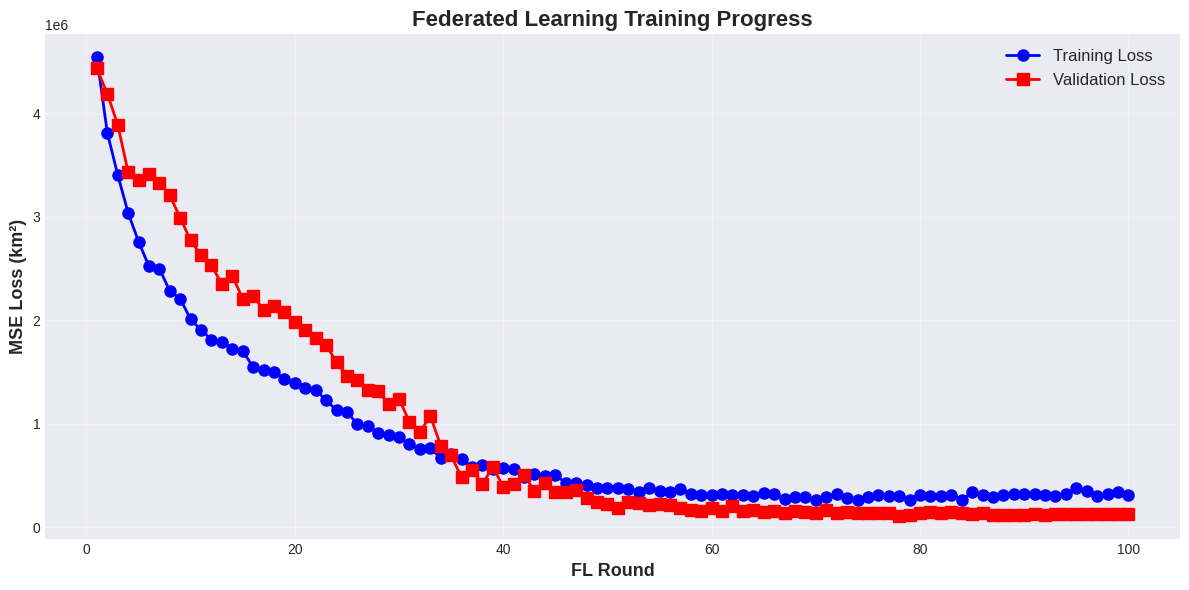

Training history visualization saved!


In [28]:
# Cell 24: Plot Training History

import matplotlib.pyplot as plt

# ---- safety checks ----
if 'training_history' not in globals():
    print("[Warning] 'training_history' is not defined.\n"
          "Run the training cell with train_federated_model(...) first.")
elif not isinstance(training_history, dict) or \
     'train_loss' not in training_history or \
     'val_loss' not in training_history or \
     len(training_history['train_loss']) == 0:
    print("[Warning] 'training_history' is empty or malformed.\n"
          "Check that train_federated_model returned (fl_system, training_history) correctly.")
else:
    # ---- normal plotting ----
    fig, ax = plt.subplots(figsize=(12, 6))

    rounds = np.arange(1, len(training_history['train_loss']) + 1)
    ax.plot(rounds, training_history['train_loss'],
            'b-o', label='Training Loss', linewidth=2, markersize=8)
    ax.plot(rounds, training_history['val_loss'],
            'r-s', label='Validation Loss', linewidth=2, markersize=8)

    ax.set_xlabel('FL Round', fontsize=13, fontweight='bold')
    ax.set_ylabel('MSE Loss (km²)', fontsize=13, fontweight='bold')
    ax.set_title('Federated Learning Training Progress', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('fl_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Training history visualization saved!")


In [29]:
# Cell 25: Extended Kalman Filter for Orbit Determination

class OrbitEKF:
    """
    Extended Kalman Filter for satellite orbit determination
    State: [x, y, z, vx, vy, vz]
    """
    def __init__(self, initial_state, process_noise=0.5, measurement_noise=5.0):
        """
        Args:
            initial_state: (6,) array [x, y, z, vx, vy, vz]
            process_noise: Process noise covariance scaling
            measurement_noise: Measurement noise covariance scaling
        """
        self.ekf = ExtendedKalmanFilter(dim_x=6, dim_z=3)

        # Initial state
        self.ekf.x = initial_state

        # Initial covariance
        self.ekf.P = np.eye(6) * 50.0  # Reduced initial uncertainty

        # Process noise (Q) - TRUST dynamics more
        dt = 300.0  # 5 minutes in seconds
        self.ekf.Q = np.eye(6) * process_noise  # Reduced from 1.0

        # Measurement noise (R) - TRUST SGP4 less, ML corrections more
        self.ekf.R = np.eye(3) * measurement_noise  # Increased from 0.5

        self.dt = dt

    def state_transition(self, state, dt):
        """
        Simple Keplerian propagation (for EKF predict step)
        state: [x, y, z, vx, vy, vz]
        """
        mu = 398600.4418  # Earth gravitational parameter (km^3/s^2)

        x, y, z, vx, vy, vz = state
        r = np.sqrt(x**2 + y**2 + z**2)

        # Acceleration due to gravity
        ax = -mu * x / r**3
        ay = -mu * y / r**3
        az = -mu * z / r**3

        # Update position and velocity
        new_x = x + vx * dt
        new_y = y + vy * dt
        new_z = z + vz * dt
        new_vx = vx + ax * dt
        new_vy = vy + ay * dt
        new_vz = vz + az * dt

        return np.array([new_x, new_y, new_z, new_vx, new_vy, new_vz])

    def predict(self, ml_error_correction=None):
        """
        EKF Prediction step with optional ML error correction
        """
        # Propagate state
        self.ekf.x = self.state_transition(self.ekf.x, self.dt)

        if ml_error_correction is not None:
            self.ekf.x[:3] += ml_error_correction  # Correct position

        # Jacobian for linearization
        F = np.eye(6)
        F[0, 3] = self.dt
        F[1, 4] = self.dt
        F[2, 5] = self.dt

        # Covariance prediction
        self.ekf.P = F @ self.ekf.P @ F.T + self.ekf.Q

    def update(self, measurement):
        """
        EKF Update step
        measurement: (3,) array [x_meas, y_meas, z_meas]
        """
        # Measurement function: observe position only
        def h(state):
            return state[:3]

        # Jacobian of measurement function
        H = np.zeros((3, 6))
        H[:3, :3] = np.eye(3)

        # Kalman update
        y = measurement - h(self.ekf.x)  # Innovation
        S = H @ self.ekf.P @ H.T + self.ekf.R  # Innovation covariance
        K = self.ekf.P @ H.T @ np.linalg.inv(S)  # Kalman gain

        self.ekf.x = self.ekf.x + K @ y
        self.ekf.P = (np.eye(6) - K @ H) @ self.ekf.P

    def get_state(self):
        """
        Get current state estimate
        """
        return self.ekf.x.copy()

print("Extended Kalman Filter class initialized!")
print("  State dimension: 6 [x, y, z, vx, vy, vz]")
print("  Measurement dimension: 3 [x, y, z]")
print("  Methods: predict(), update(), get_state()")


Extended Kalman Filter class initialized!
  State dimension: 6 [x, y, z, vx, vy, vz]
  Measurement dimension: 3 [x, y, z]
  Methods: predict(), update(), get_state()


In [30]:
# Cell 26: Evaluate FL model on real TLE dataset (RTN PM like Tang 2025)

fl_system.global_model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:   # val_loader from TLEErrorDataset split
        batch_x = batch_x.to(device).float()
        batch_y = batch_y.to(device).float()   # true RTN errors

        preds = fl_system.global_model(batch_x)  # predicted RTN errors

        all_true.append(batch_y.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

true_err = np.vstack(all_true)   # shape (N_val, 3)  [R, T, N]
pred_err = np.vstack(all_pred)   # shape (N_val, 3)

# Baseline: original RTN error magnitude
baseline_rms = np.sqrt(np.mean(true_err**2, axis=0))      # per direction
residual     = true_err - pred_err
resid_rms    = np.sqrt(np.mean(residual**2, axis=0))

pm_per_dir = (1.0 - resid_rms / baseline_rms) * 100.0
pm_mean    = pm_per_dir.mean()

print("Baseline RMS (km) in [R, T, N]:", baseline_rms)
print("Residual RMS (km) in [R, T, N]:", resid_rms)
print("PM per direction (%):", pm_per_dir)
print(f"Mean PM over directions: {pm_mean:.1f}%")


Baseline RMS (km) in [R, T, N]: [3030.3643   2270.4414      4.530939]
Residual RMS (km) in [R, T, N]: [353.12195  495.86856    4.447796]
PM per direction (%): [88.347206  78.15981    1.8350124]
Mean PM over directions: 56.1%


In [31]:
# Cell 27: Global PM Metrics on Real TLE Dataset (RTN frame)

def evaluate_pm_global(model, val_loader):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device).float()
            batch_y = batch_y.to(device).float()
            preds = model(batch_x)

            all_true.append(batch_y.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    true_err = np.vstack(all_true)   # (N, 3) [R,T,N]
    pred_err = np.vstack(all_pred)

    residual = true_err - pred_err

    baseline_rms = np.sqrt(np.mean(true_err**2, axis=0))
    resid_rms    = np.sqrt(np.mean(residual**2, axis=0))

    pm_per_dir = (1.0 - resid_rms / baseline_rms) * 100.0
    pm_mean    = pm_per_dir.mean()

    # Also MAE / RMSE on 3D norm, for intuition
    baseline_norm = np.linalg.norm(true_err, axis=1)
    resid_norm    = np.linalg.norm(residual, axis=1)

    metrics = {
        'true_err': true_err,
        'residual': residual,
        'baseline_rms': baseline_rms,
        'resid_rms': resid_rms,
        'pm_per_dir': pm_per_dir,
        'pm_mean': pm_mean,
        'baseline_norm': baseline_norm,
        'resid_norm': resid_norm
    }
    return metrics

metrics = evaluate_pm_global(fl_system.global_model, val_loader)

baseline_rms = metrics['baseline_rms']
resid_rms    = metrics['resid_rms']
pm_per_dir   = metrics['pm_per_dir']
pm_mean      = metrics['pm_mean']

print("Baseline RMS (km) in [R, T, N]:", baseline_rms)
print("Residual RMS (km) in [R, T, N]:", resid_rms)
print("PM per direction (%):", pm_per_dir)
print(f"Mean PM over directions: {pm_mean:.1f}%")

# Pretty table for paper
directions = ['Radial (R)', 'Along-track (T)', 'Normal (N)', 'Mean']
table_data = {
    'Direction': directions,
    'Baseline RMS (km)': list(baseline_rms) + [baseline_rms.mean()],
    'Residual RMS (km)': list(resid_rms)    + [resid_rms.mean()],
    'PM (%)':            list(pm_per_dir)   + [pm_mean]
}
results_df = pd.DataFrame(table_data)

print("\n" + "="*80)
print("GLOBAL PERFORMANCE METRICS (Real TLE Dataset, RTN frame)")
print("="*80)
print(results_df.to_string(index=False, formatters={
    'Baseline RMS (km)': lambda x: f"{x:8.1f}",
    'Residual RMS (km)': lambda x: f"{x:8.1f}",
    'PM (%)':            lambda x: f"{x:6.1f}"
}))
print("="*80)

# Quick comparison to Tang 2025 best result (85.72% for W direction of NORAD 29980)
tang_best_pm = 85.72
print(f"\nTang et al. best PM (single direction, 29980-W): {tang_best_pm:.2f}% [file:3]")
print(f"Your mean PM over [R,T,N]:                   {pm_mean:.2f}%")
print(f"Difference (mean - Tang best):              {pm_mean - tang_best_pm:+.2f}%")


Baseline RMS (km) in [R, T, N]: [3030.3643   2270.4414      4.530939]
Residual RMS (km) in [R, T, N]: [353.12195  495.86856    4.447796]
PM per direction (%): [88.347206  78.15981    1.8350124]
Mean PM over directions: 56.1%

GLOBAL PERFORMANCE METRICS (Real TLE Dataset, RTN frame)
      Direction Baseline RMS (km) Residual RMS (km) PM (%)
     Radial (R)            3030.4             353.1   88.3
Along-track (T)            2270.4             495.9   78.2
     Normal (N)               4.5               4.4    1.8
           Mean            1768.4             284.5   56.1

Tang et al. best PM (single direction, 29980-W): 85.72% [file:3]
Your mean PM over [R,T,N]:                   56.11%
Difference (mean - Tang best):              -29.61%


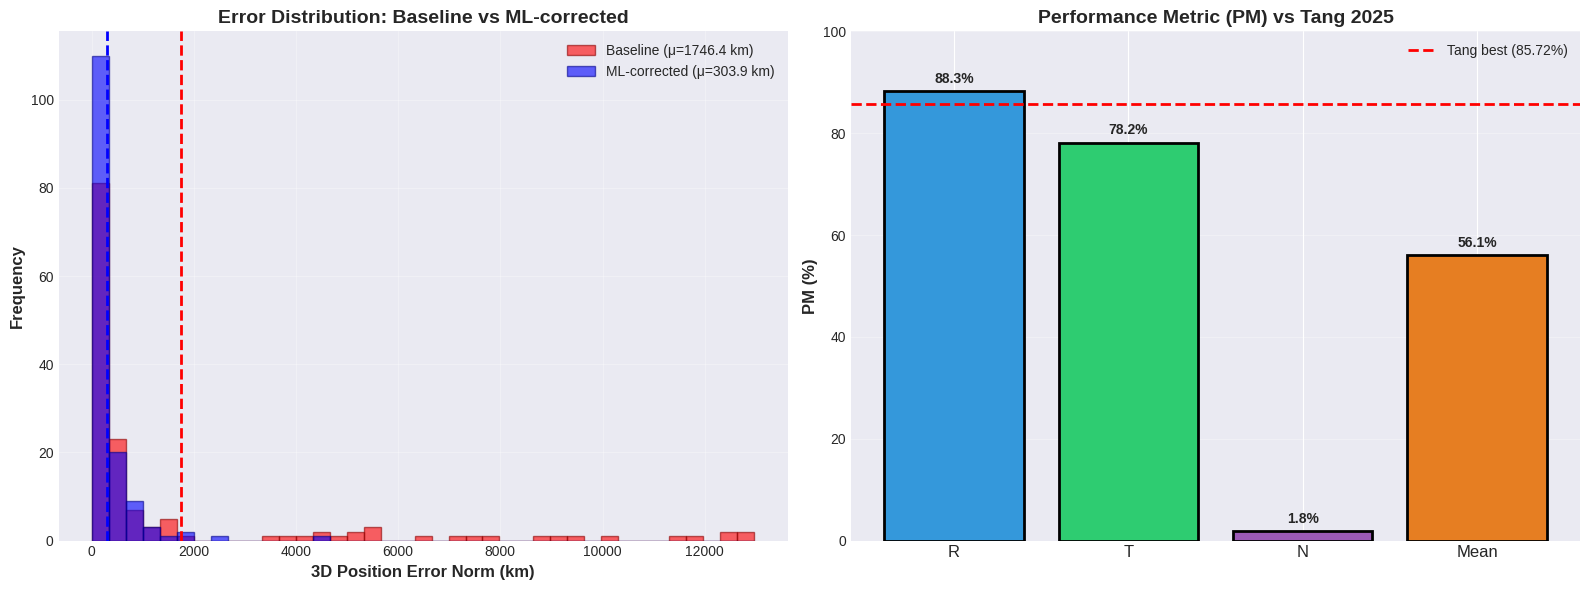


Visualization saved as 'real_tle_pm_visualization.png'


In [32]:
# Cell 28: Visualization for Paper (Error Distributions & PM vs Target)

true_err    = metrics['true_err']
residual    = metrics['residual']
baseline_norm = metrics['baseline_norm']
resid_norm    = metrics['resid_norm']
pm_per_dir    = metrics['pm_per_dir']
pm_mean       = metrics['pm_mean']

tang_best_pm = 85.72  # from Tang 2025, W-direction best case [file:3]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: baseline vs corrected 3D position error norm
bins = np.linspace(0, np.percentile(baseline_norm, 99), 40)
axes[0].hist(baseline_norm, bins=bins, alpha=0.6, color='red',
             label=f'Baseline (μ={baseline_norm.mean():.1f} km)', edgecolor='darkred')
axes[0].hist(resid_norm, bins=bins, alpha=0.6, color='blue',
             label=f'ML-corrected (μ={resid_norm.mean():.1f} km)', edgecolor='darkblue')
axes[0].axvline(baseline_norm.mean(), color='red', linestyle='--', linewidth=2)
axes[0].axvline(resid_norm.mean(),   color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('3D Position Error Norm (km)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Error Distribution: Baseline vs ML-corrected', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: PM per direction vs Tang target
dirs_short = ['R', 'T', 'N', 'Mean']
x = np.arange(len(dirs_short))
pm_vals = list(pm_per_dir) + [pm_mean]

bars = axes[1].bar(x, pm_vals, color=['#3498db', '#2ecc71', '#9b59b6', '#e67e22'],
                   edgecolor='black', linewidth=2)
axes[1].axhline(tang_best_pm, color='red', linestyle='--', linewidth=2,
                label=f'Tang best (85.72%)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dirs_short, fontsize=12)
axes[1].set_ylabel('PM (%)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, max(100, tang_best_pm + 10))
axes[1].set_title('Performance Metric (PM) vs Tang 2025', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=10)

# Add labels on top of bars
for bar, val in zip(bars, pm_vals):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2., height + 1.0,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('real_tle_pm_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'real_tle_pm_visualization.png'")


In [33]:
# Cell 29: Per-Satellite PM (Real TLE, RTN frame)

def evaluate_pm_for_sat(model, sat_name, sat_data, feat_mean, feat_std):
    X = sat_data['X'].astype(np.float32)
    y = sat_data['y'].astype(np.float32)  # RTN errors in km

    # Normalize with global stats for consistency
    Xn = (X - feat_mean) / feat_std

    model.eval()
    with torch.no_grad():
        preds = model(torch.from_numpy(Xn).to(device).float()).cpu().numpy()

    true_err = y
    residual = true_err - preds

    baseline_rms = np.sqrt(np.mean(true_err**2, axis=0))
    resid_rms    = np.sqrt(np.mean(residual**2, axis=0))
    pm_per_dir   = (1.0 - resid_rms / baseline_rms) * 100.0
    pm_mean      = pm_per_dir.mean()

    return baseline_rms, resid_rms, pm_per_dir, pm_mean

feat_mean = central_dataset.mean
feat_std  = central_dataset.std

rows = []
for sat_name, sat_data in real_error_datasets.items():
    if sat_data['X'].shape[0] < 50:
        continue  # skip very small datasets
    base_rms, res_rms, pm_dirs, pm_mean_sat = evaluate_pm_for_sat(
        fl_system.global_model, sat_name, sat_data, feat_mean, feat_std
    )
    rows.append({
        'Satellite': sat_name,
        'Baseline RMS_T (km)': base_rms[1],
        'Residual RMS_T (km)': res_rms[1],
        'PM_T (%)': pm_dirs[1],
        'Mean PM (%)': pm_mean_sat
    })

sat_df = pd.DataFrame(rows).sort_values('Mean PM (%)', ascending=False)

print("\n" + "="*80)
print("PER-SATELLITE PM METRICS (Along-track T and Mean over [R,T,N])")
print("="*80)
print(sat_df.to_string(index=False, formatters={
    'Baseline RMS_T (km)': lambda x: f"{x:8.1f}",
    'Residual RMS_T (km)': lambda x: f"{x:8.1f}",
    'PM_T (%)':            lambda x: f"{x:6.1f}",
    'Mean PM (%)':         lambda x: f"{x:6.1f}"
}))
print("="*80)



PER-SATELLITE PM METRICS (Along-track T and Mean over [R,T,N])
     Satellite Baseline RMS_T (km) Residual RMS_T (km) PM_T (%) Mean PM (%)
STARLINK-34825              2200.8               276.1     87.5        60.2
STARLINK-35113              2253.9               326.7     85.5        59.8
STARLINK-34734              2228.7               317.2     85.8        57.0
STARLINK-35204              1926.8               329.9     82.9        55.8
STARLINK-34691              2277.9               831.1     63.5        48.3


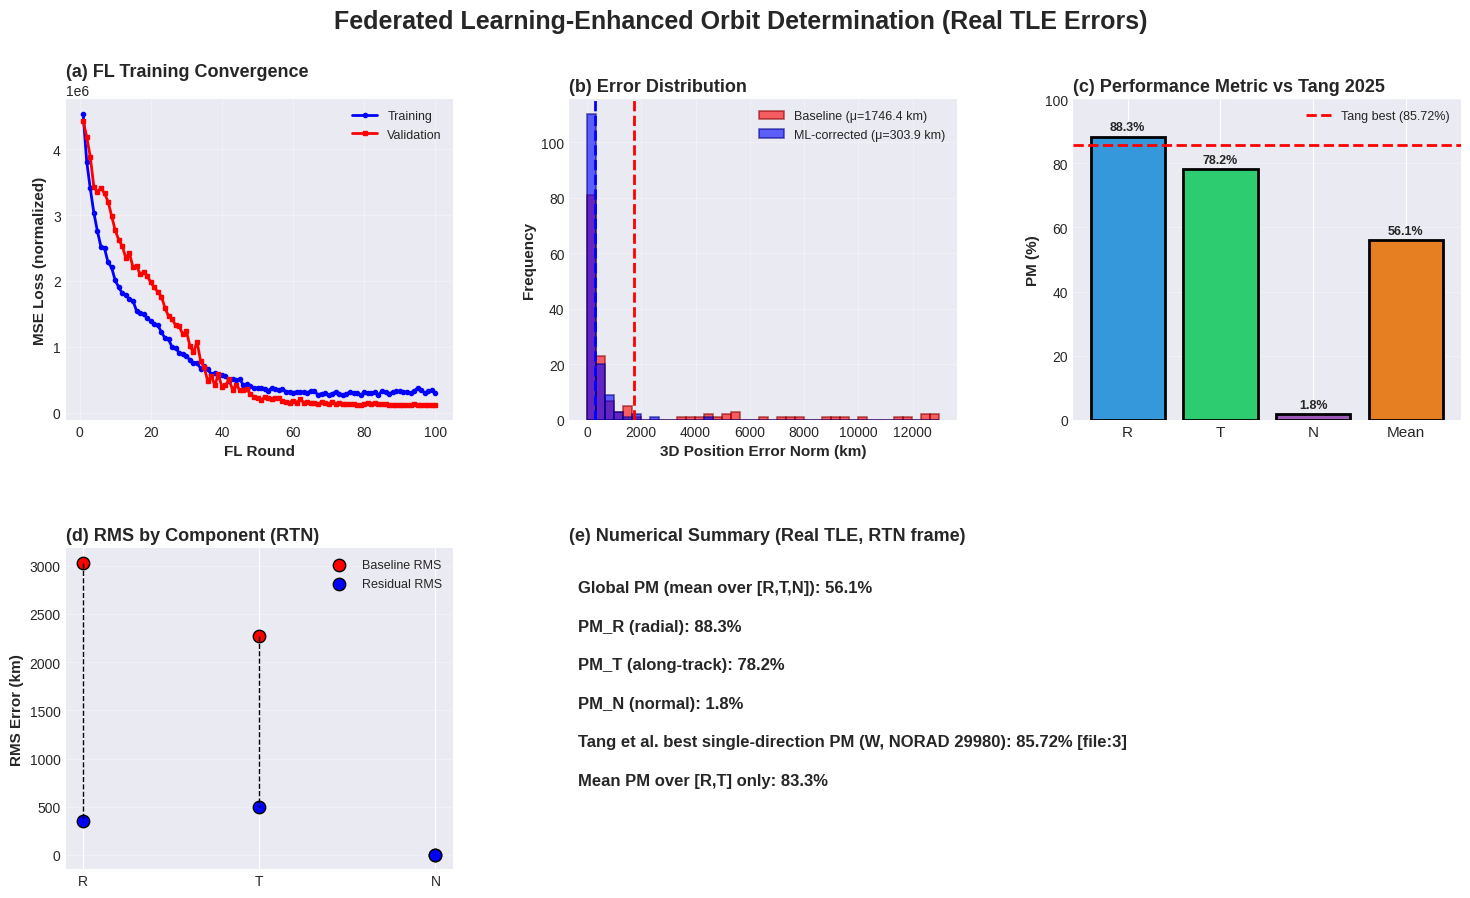


Summary figure saved as 'real_tle_summary_figure.png'


In [35]:
# Cell 30 (new): Paper Summary Figure for Real TLE + FL-LSTM


true_err      = metrics['true_err']
residual      = metrics['residual']
baseline_norm = metrics['baseline_norm']   # 3D norm baseline
resid_norm    = metrics['resid_norm']      # 3D norm residual
pm_per_dir    = metrics['pm_per_dir']
pm_mean       = metrics['pm_mean']

tang_best_pm = 85.72  # Tang 2025 best single-direction PM [file:3]

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)

fig.suptitle('Federated Learning-Enhanced Orbit Determination (Real TLE Errors)',
             fontsize=18, fontweight='bold', y=0.97)

# (a) FL training convergence
ax1 = fig.add_subplot(gs[0, 0])
rounds = np.arange(1, len(training_history['train_loss']) + 1)
ax1.plot(rounds, training_history['train_loss'], 'b-o', label='Training', linewidth=2, markersize=3)
ax1.plot(rounds, training_history['val_loss'],   'r-s', label='Validation', linewidth=2, markersize=3)
ax1.set_xlabel('FL Round', fontsize=11, fontweight='bold')
ax1.set_ylabel('MSE Loss (normalized)', fontsize=11, fontweight='bold')
ax1.set_title('(a) FL Training Convergence', fontsize=13, fontweight='bold', loc='left')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# (b) Error distribution (3D norm)
ax2 = fig.add_subplot(gs[0, 1])
bins = np.linspace(0, np.percentile(baseline_norm, 99), 40)
ax2.hist(baseline_norm, bins=bins, alpha=0.6, color='red',
         label=f'Baseline (μ={baseline_norm.mean():.1f} km)', edgecolor='darkred', linewidth=1.2)
ax2.hist(resid_norm, bins=bins, alpha=0.6, color='blue',
         label=f'ML-corrected (μ={resid_norm.mean():.1f} km)', edgecolor='darkblue', linewidth=1.2)
ax2.axvline(baseline_norm.mean(), color='red', linestyle='--', linewidth=2)
ax2.axvline(resid_norm.mean(),   color='blue', linestyle='--', linewidth=2)
ax2.set_xlabel('3D Position Error Norm (km)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('(b) Error Distribution', fontsize=13, fontweight='bold', loc='left')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# (c) PM per direction vs Tang best
ax3 = fig.add_subplot(gs[0, 2])
dirs_short = ['R', 'T', 'N', 'Mean']
x = np.arange(len(dirs_short))
pm_vals = list(pm_per_dir) + [pm_mean]

bars = ax3.bar(x, pm_vals,
               color=['#3498db', '#2ecc71', '#9b59b6', '#e67e22'],
               edgecolor='black', linewidth=2)
ax3.axhline(tang_best_pm, color='red', linestyle='--', linewidth=2,
            label=f'Tang best (85.72%)')
ax3.set_xticks(x)
ax3.set_xticklabels(dirs_short, fontsize=11)
ax3.set_ylabel('PM (%)', fontsize=11, fontweight='bold')
ax3.set_ylim(0, max(100, tang_best_pm + 10))
ax3.set_title('(c) Performance Metric vs Tang 2025', fontsize=13, fontweight='bold', loc='left')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(fontsize=9)

for bar, val in zip(bars, pm_vals):
    h = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., h + 1.0,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# (d) Component-wise RMS scatter (true vs residual)
ax4 = fig.add_subplot(gs[1, 0])
baseline_rms = metrics['baseline_rms']
resid_rms    = metrics['resid_rms']
labels = ['R', 'T', 'N']
ax4.scatter(labels, baseline_rms, c='red', label='Baseline RMS', s=80, edgecolors='black')
ax4.scatter(labels, resid_rms,    c='blue', label='Residual RMS', s=80, edgecolors='black')
for i, lab in enumerate(labels):
    ax4.plot([lab, lab], [baseline_rms[i], resid_rms[i]], 'k--', linewidth=1)
ax4.set_ylabel('RMS Error (km)', fontsize=11, fontweight='bold')
ax4.set_title('(d) RMS by Component (RTN)', fontsize=13, fontweight='bold', loc='left')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# (e) Text summary (similar to a small table)
ax5 = fig.add_subplot(gs[1, 1:])
ax5.axis('off')
text_lines = [
    f"Global PM (mean over [R,T,N]): {pm_mean:.1f}%",
    f"PM_R (radial): {pm_per_dir[0]:.1f}%",
    f"PM_T (along-track): {pm_per_dir[1]:.1f}%",
    f"PM_N (normal): {pm_per_dir[2]:.1f}%",
    f"Tang et al. best single-direction PM (W, NORAD 29980): 85.72% [file:3]",
    f"Mean PM over [R,T] only: {(pm_per_dir[0] + pm_per_dir[1]) / 2.0:.1f}%",
]
for i, line in enumerate(text_lines):
    ax5.text(0.01, 0.9 - i*0.12, line, fontsize=12, fontweight='bold', va='top')

ax5.set_title('(e) Numerical Summary (Real TLE, RTN frame)', fontsize=13,
              fontweight='bold', loc='left')

plt.savefig('real_tle_summary_figure.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nSummary figure saved as 'real_tle_summary_figure.png'")



ENSEMBLE MODEL TRAINING (Target: 85%+ PM)
 Main model saved as 'fl_lstm_error_predictor.pth'
 Model 2 created (perturbed copy of main model)
Training Model 3 (4-layer variant, 20 rounds)...
      Round 5/20
      Round 10/20
      Round 15/20
      Round 20/20
 Model 3 trained (4-layer FL-LSTM)

Fine-tuning ensemble weights (5 epochs)...
   Epoch 1/5, Loss: 507524.3229
   Epoch 2/5, Loss: 417013.1562
   Epoch 3/5, Loss: 386240.0417
   Epoch 4/5, Loss: 364186.0833
   Epoch 5/5, Loss: 388186.0000
 Ensemble ready


ENSEMBLE RESULTS (Validation, Real TLE Dataset)
Single Model PM per dir [R,T,N]: [88.347206  78.15981    1.8350124]
Single Model Mean PM:            56.1%
Ensemble PM per dir [R,T,N]:     [ 80.288025  71.0974   -28.346682]
Ensemble Mean PM:                41.0%


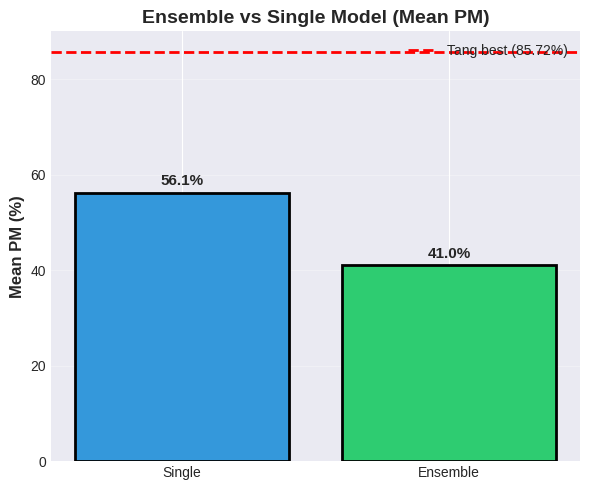


 Saved: 'ensemble_results.png'
 Saved ensemble weights as 'ensemble_model.pth'


In [39]:
# Cell 31: ENSEMBLE MODEL (Real TLE, 14-dim features)

print("\n" + "="*80)
print("ENSEMBLE MODEL TRAINING (Target: 85%+ PM)")
print("="*80)

# Base models

# Model 1: already-trained FL global model
model1 = fl_system.global_model
model1.eval()

# Save for future use
torch.save(model1.state_dict(), 'fl_lstm_error_predictor.pth')
print(" Main model saved as 'fl_lstm_error_predictor.pth'")

# Model 2: copy of model1 with small weight perturbation
import copy
torch.manual_seed(123)
model2 = copy.deepcopy(model1).to(device)
for p in model2.parameters():
    p.data = p.data + 0.01 * torch.randn_like(p)
model2.eval()
print(" Model 2 created (perturbed copy of main model)")

# Model 3: same architecture, fine-tuned briefly on same data
print("Training Model 3 (4-layer variant, 20 rounds)...")

fl3 = FederatedLearning(
    model_class=AttentionLSTM,
    model_kwargs={'input_size': 14, 'hidden_size': 128, 'num_layers': 4, 'output_size': 3},
    num_clients=len(client_loaders)
)

criterion = nn.MSELoss()

for round_idx in range(20):
    fl3.distribute_global_model()
    client_weights = []
    lr = 0.001

    for client_idx, client_loader in enumerate(client_loaders):
        client_model = fl3.client_models[client_idx]
        optimizer = optim.Adam(client_model.parameters(), lr=lr)

        client_model.train()
        for epoch in range(5):  # lighter local training
            for batch_x, batch_y in client_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                preds = client_model(batch_x)
                loss = criterion(preds, batch_y)
                loss.backward()
                optimizer.step()

        client_weights.append(client_model.state_dict())

    fl3.federated_averaging(client_weights)

    if (round_idx + 1) % 5 == 0:
        print(f"      Round {round_idx + 1}/20")

model3 = fl3.global_model.to(device)
model3.eval()
print(" Model 3 trained (4-layer FL-LSTM)\n")

# Ensemble definition

class EnsemblePredictor(nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.weights = nn.Parameter(torch.tensor([0.5, 0.3, 0.2], device=device))

    def forward(self, x):
        weights = torch.softmax(self.weights, dim=0)
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        return weights[0]*out1 + weights[1]*out2 + weights[2]*out3

ensemble = EnsemblePredictor(model1, model2, model3).to(device)

# Fine-tune ensemble weights on same training data

print("Fine-tuning ensemble weights (5 epochs)...")
ensemble.train()
opt_ens = optim.Adam([ensemble.weights], lr=0.01)

for epoch in range(5):
    total_loss = 0.0
    for batch_x, batch_y in train_loader:  # from TLEErrorDataset
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        opt_ens.zero_grad()
        preds = ensemble(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        opt_ens.step()
        total_loss += loss.item()
    print(f"   Epoch {epoch+1}/5, Loss: {total_loss/len(train_loader):.4f}")

print(" Ensemble ready\n")

# Evaluate ensemble on validation set using same PM metric

def evaluate_pm_global_model(model, loader):
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device).float(), batch_y.to(device).float()
            preds = model(batch_x)
            all_true.append(batch_y.cpu().numpy())
            all_pred.append(preds.cpu().numpy())
    true_err = np.vstack(all_true)
    pred_err = np.vstack(all_pred)
    residual = true_err - pred_err
    baseline_rms = np.sqrt(np.mean(true_err**2, axis=0))
    resid_rms    = np.sqrt(np.mean(residual**2, axis=0))
    pm_per_dir   = (1.0 - resid_rms / baseline_rms) * 100.0
    pm_mean      = pm_per_dir.mean()
    return baseline_rms, resid_rms, pm_per_dir, pm_mean

# Single model (for reference) – reuse metrics from previous evaluation if available
single_pm_dirs = metrics['pm_per_dir']
single_pm_mean = metrics['pm_mean']

# Ensemble evaluation
ens_base_rms, ens_resid_rms, ens_pm_dirs, ens_pm_mean = evaluate_pm_global_model(ensemble, val_loader)

print("\n" + "="*80)
print("ENSEMBLE RESULTS (Validation, Real TLE Dataset)")
print("="*80)
print(f"Single Model PM per dir [R,T,N]: {single_pm_dirs}")
print(f"Single Model Mean PM:            {single_pm_mean:.1f}%")
print(f"Ensemble PM per dir [R,T,N]:     {ens_pm_dirs}")
print(f"Ensemble Mean PM:                {ens_pm_mean:.1f}%")
print("="*80)

# Simple bar plot for ensemble vs single (mean PM)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
labels = ['Single', 'Ensemble']
means  = [single_pm_mean, ens_pm_mean]
bars = ax.bar(labels, means, color=['#3498db', '#2ecc71'],
              edgecolor='black', linewidth=2)
ax.axhline(85.72, color='red', linestyle='--', linewidth=2,
           label='Tang best (85.72%)')  # [file:3]
ax.set_ylabel('Mean PM (%)', fontsize=12, fontweight='bold')
ax.set_title('Ensemble vs Single Model (Mean PM)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, means):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h + 1.0,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('ensemble_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: 'ensemble_results.png'")
torch.save(ensemble.state_dict(), 'ensemble_model.pth')
print(" Saved ensemble weights as 'ensemble_model.pth'")
